# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
g_demo = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')

# Load in the feature summary file.
g_summ = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print("Number of rows and columns in General demo data:", g_demo.shape)
print("First few rows of General demo data:")
print(g_demo.head())

print("\nNumber of rows and columns in General summary data:", g_summ.shape)
print("First few rows of General summary data:")
print(g_summ.head())

Number of rows and columns in General demo data: (891221, 85)
First few rows of General demo data:
   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR  \
0            

In [4]:
g_demo.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Identify missing or unknown data values and convert them to NaNs.

#Function to parse string data
def parse_data(a):
    try:
        return eval(a)
    except:
        return []
    
g_summ['missing_parsed'] = g_summ['missing_or_unknown'].apply(parse_data)

#Function to convert into NaN
for i in range(len(g_summ)):

    column_name = g_summ.loc[i, 'attribute'] 

    if column_name in g_demo.columns:
        missing_values = g_summ.loc[i, 'missing_parsed']
        g_demo[column_name] = g_demo[column_name].replace(missing_values, np.nan)

In [6]:
g_demo.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,NaN,2.0,5,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,NaN,1.0,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,NaN,1.0,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,NaN,2.0,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [7]:
g_demo.OST_WEST_KZ.unique()

array([nan, 'W', 'O'], dtype=object)

In [8]:
# Open the .md file in read mode to understand the data
with open('Data_Dictionary.md', 'r', encoding='utf-8') as file:
    content = file.read()

print(content)

# Data Dictionary for Identify Customer Segments Data

## Introduction

The data for this project consist of two files:

- Udacity_AZDIAS_Subset.csv: demographics data for the general population of
      Germany; 891211 persons (rows) x 85 features (columns)
- Udacity_CUSTOMERS_Subset.csv: demographics data for customers of a mail-order
      company; 191652 persons (rows) x 85 features (columns)

The columns in the general demographics file and customers data file are the
same. This file documents the features that appear in the data files, sorted in
order of appearance. Sections of this file is based on the level of measurement
of each feature. The file "AZDIAS_Feature_Summary.csv" contains a summary of
feature attributes, including information level, data type, and codes for
missing or unknown values.

### Table of Contents

 1. Person-level features
 2. Household-level features
 3. Building-level features
 4. RR4 micro-cell features
 5. RR3 micro-cell features
 6. Postcode-level fe

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [9]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

#Missing data % for each column
missing_data = g_demo.isnull().mean()*100

# Convert the result to a DataFrame for better visualization
missing_data_df = pd.DataFrame(missing_data, columns=['Percentage Missing'])

# Sort the DataFrame by the percentage of missing data in descending order
missing_data_df = missing_data_df.sort_values(by='Percentage Missing', ascending=False)

# Display the missing data assessment
missing_data_df

,Percentage Missing
TITEL_KZ,99.757636
AGER_TYP,76.955435
KK_KUNDENTYP,65.596749
KBA05_BAUMAX,53.468668
GEBURTSJAHR,44.020282
ALTER_HH,34.813699
KKK,17.735668
REGIOTYP,17.735668
W_KEIT_KIND_HH,16.605084
KBA05_ANTG1,14.959701


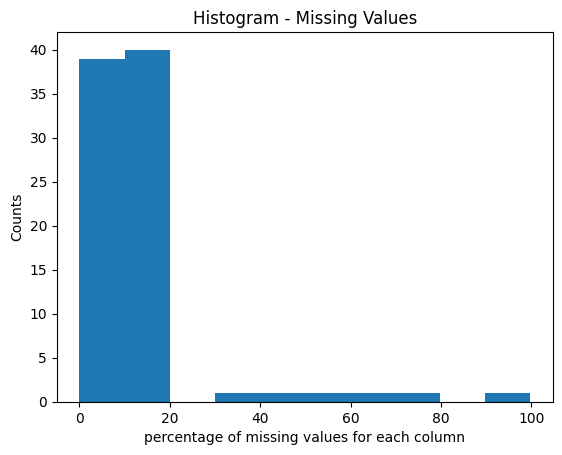

In [10]:
# Investigate patterns in the amount of missing data in each column

plt.hist(missing_data_df)
plt.xlabel('percentage of missing values for each column')
plt.ylabel('Counts')
plt.title('Histogram - Missing Values')
plt.show()

Text(0, 0.5, 'Percentage Missing')

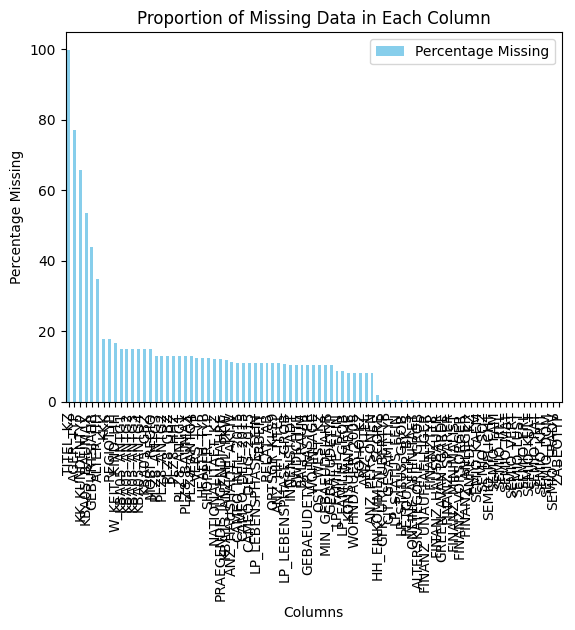

In [11]:
# Plotting the proportion of missing data in each column
missing_data_df.plot(kind='bar', color='skyblue')
plt.title('Proportion of Missing Data in Each Column')
plt.xlabel('Columns')
plt.ylabel('Percentage Missing')

In [12]:
#Outlier Treatment

# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

missing_data_proportion = g_demo.isnull().mean()

#Outlier columns with more than 50% missing values
outlier_columns = missing_data_proportion[missing_data_proportion > 0.5].index

# Drop the columns
g_demo = g_demo.drop(columns=outlier_columns)

# Verify the remaining columns
remaining_columns = g_demo.columns
print(f"Remaining Columns after removing outliers: {remaining_columns}")

Remaining Columns after removing outliers: Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ALTER_HH',
       'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP',
       'KONSUMNAEHE', 'MIN_GEBA

In [13]:
g_demo.shape

(891221, 81)

#### Discussion 1.1.2: Assess Missing Data in Each Column
**Observations:**

Amount of missing data: 
Percentage of missing values is around 20% for most columns

Columns removed:
4 columns were removed  where each column had > 50% data missing 
['AGER_TYP', 'TITEL_KZ', 'KK_KUNDENTYP', 'KBA05_BAUMAX']

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [14]:
# How much data is missing in each row of the dataset?

# 1. Calculate the number of missing values for each row
missing_per_row = g_demo.isnull().sum(axis=1)

(array([6.88296e+05, 7.39370e+04, 2.38640e+04, 1.04410e+04, 1.25800e+03,
        2.58000e+02, 9.25000e+03, 9.66600e+03, 7.11000e+02, 7.35400e+04]),
 array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]),
 <BarContainer object of 10 artists>)

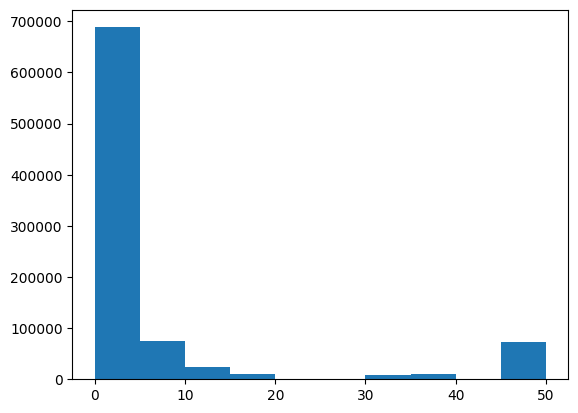

In [15]:
plt.hist(missing_per_row)

In [16]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Define the threshold
threshold = 0.3 * g_demo.shape[1]  # 30% of total columns as seen in histogram above

# Divide the dataset into two subsets
rows_with_many_missing = g_demo[missing_per_row > threshold]
rows_with_few_missing = g_demo[missing_per_row <= threshold]

In [17]:
rows_with_many_missing.shape, rows_with_few_missing.shape

((93425, 81), (797796, 81))

In [18]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
few_missing_columns = g_demo.columns[g_demo.isnull().mean() <= 0.05]

# Select at least five columns from the identified ones
selected_columns = few_missing_columns[:5]  # Take the first 5 columns
selected_columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER'],
      dtype='object')

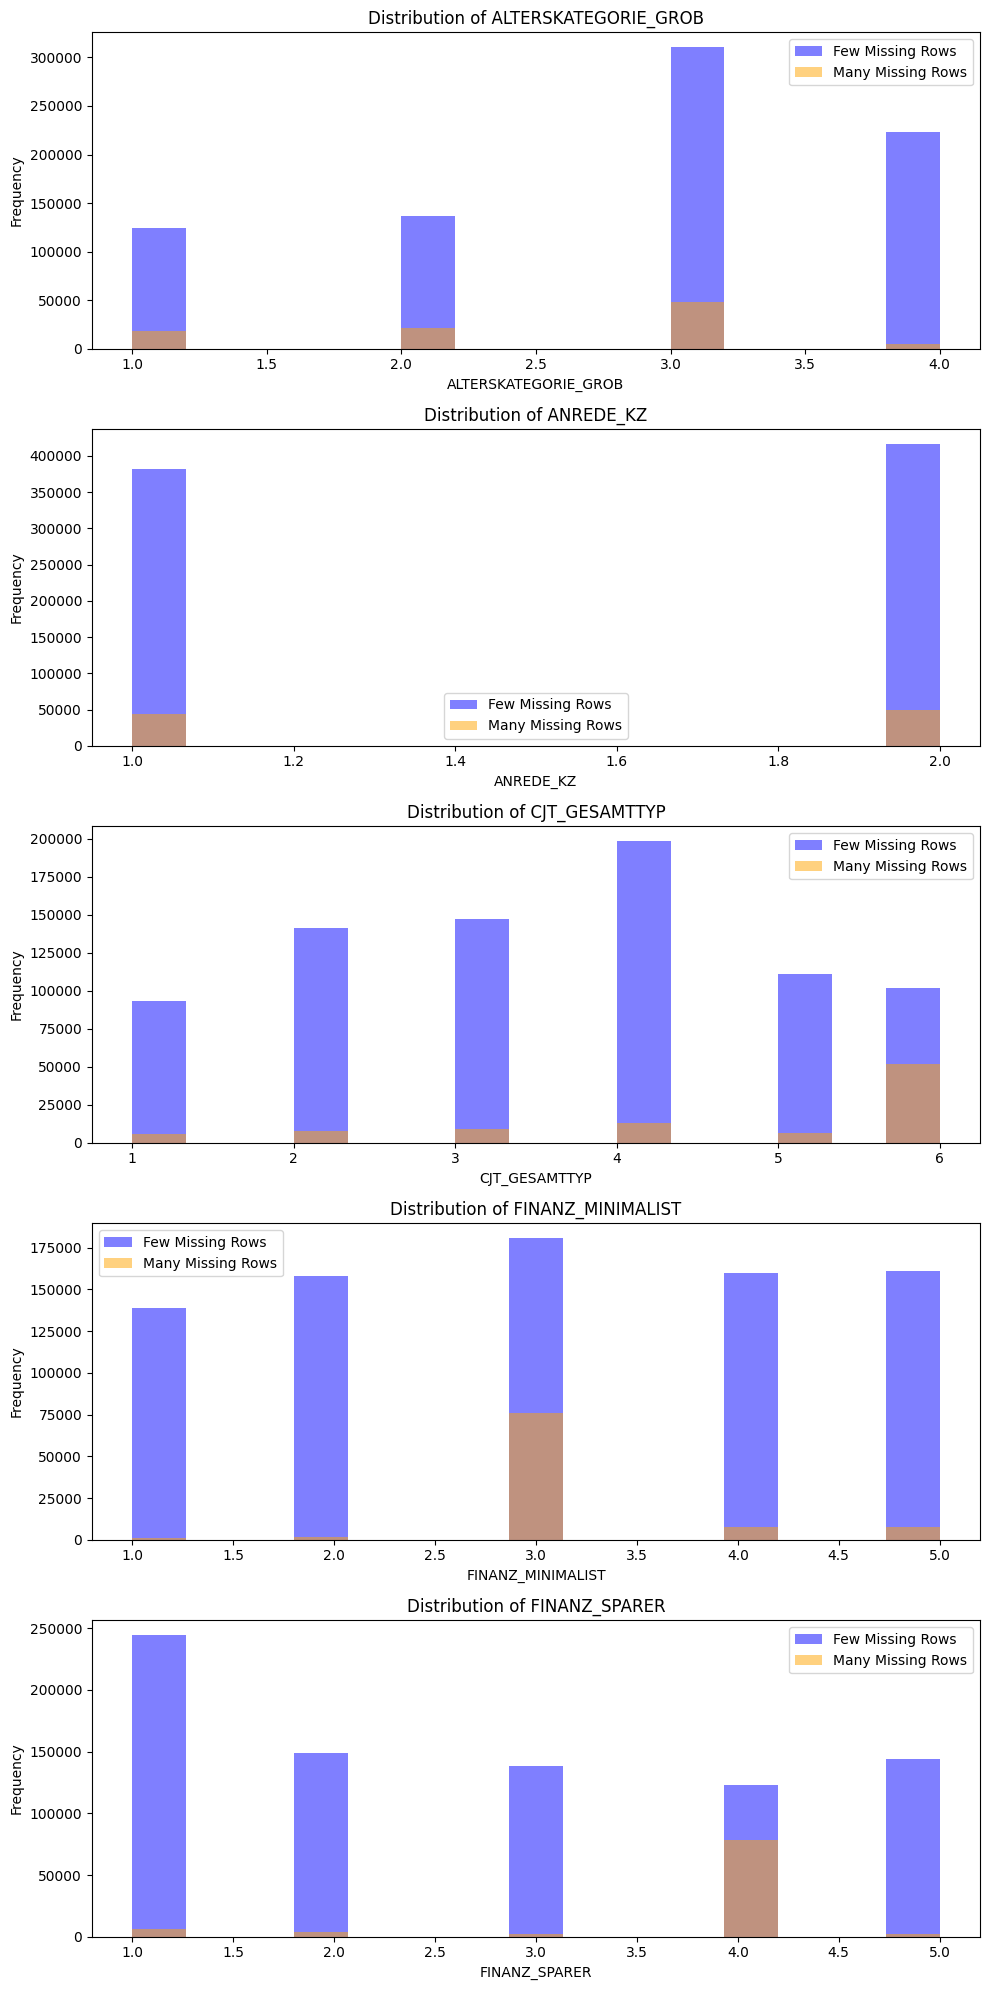

In [19]:
 # Plot side-by-side histograms
fig, axes = plt.subplots(len(selected_columns), 1, figsize=(10, 20))

for i, col in enumerate(selected_columns):
    ax = axes[i]
    
    # Plot for rows with few missing values
    ax.hist(rows_with_few_missing[col].dropna(), bins=15, alpha=0.5, label='Few Missing Rows', color='blue')
    
    # Plot for rows with many missing values
    ax.hist(rows_with_many_missing[col].dropna(), bins=15, alpha=0.5, label='Many Missing Rows', color='orange')
    
    # Title and legend
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout()
plt.show()

#### Discussion 1.1.3: Assess Missing Data in Each Row

The large discrepancy in row counts (93,425 vs. 797,796) suggests that the dataset is predominantly complete, with most rows having minimal missing values

Next Steps:
Impute values for rows with many missing data with mean if they are not qualitatively different, to retain as much information as possible.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [20]:
g_summ.type.unique()

array(['categorical', 'ordinal', 'numeric', 'mixed', 'interval'],
      dtype=object)

In [21]:
# How many features are there of each data type?
feature_counts = g_summ['type'].value_counts()
feature_counts

type
ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: count, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [22]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Filter categorical variables
categorical_indices = g_summ[g_summ['type'] == 'categorical'].index
categorical_columns = g_summ.loc[categorical_indices, 'attribute']

# Columns removed as outliers
outlier_columns = ['AGER_TYP', 'TITEL_KZ', 'KK_KUNDENTYP']
# Remove them from categorical_columns
categorical_columns = [col for col in categorical_columns if col not in outlier_columns]

categorical_columns

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [25]:
# Separate Binary and Multi-Level Features

# Step 1: Calculate unique counts for categorical columns
unique_counts = g_demo[categorical_columns].nunique()

# Step 2: Filter binary and multi-level categorical variables
binary_vars = unique_counts[unique_counts == 2].index.tolist()
multi_level_vars = unique_counts[unique_counts > 2].index.tolist()

# Step 3: Print statements
print("Binary Variables:", binary_vars)
print("Multi-level Variables:", multi_level_vars)

Binary Variables: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
Multi-level Variables: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [26]:
#Re-encoding Binary categorical variables

# Define a function for re-encoding binary categorical variables
def reencode_binary(col):
    if col.name == 'ANREDE_KZ':  # Example column name for gender
        return col.map({1: 1, 2: 0})  # Map 1 and 2 to 1, and other values to 0
    elif col.name == 'GREEN_AVANTGARDE':  # Example column name for green avantgarde membership
        return col.map({1: 1, 0: 0})  # Map 1 to 1, and 0 to 0
    elif col.name == 'SOHO_KZ':  # Example column name for small office/home office flag
        return col.map({0: 0, 1: 1})  # Map 0 to 0, and 1 to 1
    elif col.name == 'OST_WEST_KZ':  # Example column name for building location
        return col.map({'W': 1, 'O': 0})  # Map 'W' to 1, and 'O' to 0
    elif col.name == 'VERS_TYP':
        return col.map({1:1, 2:0}) # Map 1 and 2 to 1, 0

# Apply the re-encoding to each of the specified binary columns
for col in binary_vars:
    g_demo[col] = reencode_binary(g_demo[col])

In [27]:
# Re-encode categorical variable(s) to be kept in the analysis.

from sklearn.preprocessing import OneHotEncoder

# Apply One-Hot Encoding to each multi-level variable
for var in multi_level_vars:
    # Use pandas get_dummies for encoding
    encoded = pd.get_dummies(g_demo[var], prefix=var, drop_first=True)
    g_demo = pd.concat([g_demo, encoded], axis=1)
    # Drop the original multi-level column
    g_demo.drop(var, axis=1, inplace=True)

# Check the resulting dataframe
print(g_demo.head())

   ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                   2.0          1                  3              4   
1                   1.0          0                  1              5   
2                   3.0          0                  1              4   
3                   4.0          0                  4              2   
4                   3.0          1                  4              3   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0                 3               5                      5                 3   
1                 2               5                      4                 5   
2                 1               2                      3                 5   
3                 5               2                      1                 2   
4                 4               1                      3                 2   

   GEBURTSJAHR  GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  \
0          NaN   

In [28]:
g_demo.shape

(891221, 185)

#### Discussion 1.2.1: Re-Encode Categorical Features

Re-encoded binary columns with 0's and 1's:
Binary Variables: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

Used OneHotEncoder for the Multi-level Variables:
Multi-level Variables: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [29]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.


# Map PRAEGENDE_JUGENDJAHRE to decade and movement
def map_decade(value):
    if value in [1, 2]:
        return 40
    elif value in [3, 4]:
        return 50
    elif value in [5, 6, 7]:
        return 60
    elif value in [8, 9]:
        return 70
    elif value in [10, 11, 12, 13]:
        return 80
    elif value in [14, 15]:
        return 90
    return None  # Exclude unknown values

def map_movement(value):
    if value in [1, 3, 5, 8, 10, 12, 14]:  # Mainstream
        return 0
    elif value in [2, 4, 6, 7, 9, 11, 13, 15]:  # Avantgarde
        return 1
    return None  # Exclude unknown values

g_demo['decade'] = g_demo['PRAEGENDE_JUGENDJAHRE'].apply(map_decade)
g_demo['movement'] = g_demo['PRAEGENDE_JUGENDJAHRE'].apply(map_movement)

In [30]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Split CAMEO_INTL_2015 into wealth and life stage
def extract_wealth(value):
    try:
        return int(str(value)[0])  # Extract tens place
    except (ValueError, TypeError):
        return None  # Exclude unknown or invalid values

def extract_life_stage(value):
    try:
        return int(str(value)[1])  # Extract ones place
    except (ValueError, TypeError):
        return None  # Exclude unknown or invalid values

g_demo['wealth'] = g_demo['CAMEO_INTL_2015'].apply(extract_wealth)
g_demo['life_stage'] = g_demo['CAMEO_INTL_2015'].apply(extract_life_stage)


In [31]:
print(g_demo[['decade', 'movement']].dropna().head())
print(g_demo[['wealth', 'life_stage']].dropna().head())

   decade  movement
1    90.0       0.0
2    90.0       1.0
3    70.0       0.0
4    70.0       0.0
5    50.0       0.0
   wealth  life_stage
1     5.0         1.0
2     2.0         4.0
3     1.0         2.0
4     4.0         3.0
5     5.0         4.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

2 Mixed-type features were dissected into their component parts (e.g., numeric and categorical):

> CAMEO_INTL_2015 : Dissected in Wealth and Life Stage

> PRAEGENDE_JUGENDJAHRE : Dissected in Decade and Movement

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [32]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Drop the two columns
columns_to_drop = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']
g_demo = g_demo.drop(columns=columns_to_drop, errors='ignore')

# Verify the columns are dropped
print(g_demo.columns)

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GEBURTSJAHR',
       'GREEN_AVANTGARDE',
       ...
       'CAMEO_DEU_2015_9A', 'CAMEO_DEU_2015_9B', 'CAMEO_DEU_2015_9C',
       'CAMEO_DEU_2015_9D', 'CAMEO_DEU_2015_9E', 'CAMEO_DEU_2015_XX', 'decade',
       'movement', 'wealth', 'life_stage'],
      dtype='object', length=187)


In [33]:
g_demo.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_X,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,decade,movement,wealth,life_stage
0,2.0,1,3,4,3,5,5,3,NaN,0,NaN,15.0,4.0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN
1,1.0,0,1,5,2,5,4,5,1996.0,0,3.0,21.0,6.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,0.0,NaN,2.0,0.0,6.0,3.0,9.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [34]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    #Function to convert into NaN
    
    for i in range(len(g_summ)):

        column_name = g_summ.loc[i, 'attribute'] 
        if column_name in df.columns:
            missing_values = g_summ.loc[i, 'missing_parsed']
            df[column_name] = df[column_name].replace(missing_values, np.nan)
    
    # remove selected columns and rows, ...
    
    # Step 1: Dropping >50% missing data columns
    missing_data_proportion = df.isnull().mean()
    outlier_columns = missing_data_proportion[missing_data_proportion > 0.5].index
    df = df.drop(columns=outlier_columns)
    print("Shape of dataframe after Step 1 is : ", df.shape)
    
    # Step 2: 
    # Filter categorical variables
    categorical_indices = g_summ[g_summ['type'] == 'categorical'].index
    categorical_columns = g_summ.loc[categorical_indices, 'attribute']

    # Columns removed as outliers
    outlier_columns = ['AGER_TYP', 'TITEL_KZ', 'KK_KUNDENTYP']
    # Remove them from categorical_columns
    categorical_columns = [col for col in categorical_columns if col not in outlier_columns]
    
    # Step 3: Filter binary and multi-level categorical variables
    unique_counts = df[categorical_columns].nunique()
    binary_vars = unique_counts[unique_counts == 2].index.tolist()
    multi_level_vars = unique_counts[unique_counts > 2].index.tolist()

    # Step 4: Debug print statements
    print("Binary Variables:", binary_vars)
    print("Multi-level Variables:", multi_level_vars)
    
    # select, re-encode, and engineer column values.
    for col in binary_vars:
        df[col] = reencode_binary(df[col])
    
    # One Hot Encoding Step
    for var in multi_level_vars:
        # Use pandas get_dummies for encoding
        encoded = pd.get_dummies(df[var], prefix=var, drop_first=True)
        df = pd.concat([df, encoded], axis=1)
        # Drop the original multi-level column
        df.drop(var, axis=1, inplace=True)
    
    print("Shape after 1 Hot Encoding: ", g_demo.shape)
    
    # Return the cleaned dataframe.
    df['decade'] = df['PRAEGENDE_JUGENDJAHRE'].apply(map_decade)
    df['movement'] = df['PRAEGENDE_JUGENDJAHRE'].apply(map_movement)
    df['wealth'] = df['CAMEO_INTL_2015'].apply(extract_wealth)
    df['life_stage'] = df['CAMEO_INTL_2015'].apply(extract_life_stage)
    columns_to_drop = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']
    df = df.drop(columns=columns_to_drop, errors='ignore')

    # Verify the columns are dropped
    print(df.columns)
    
    return df

In [35]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ';')
customers = clean_data(customers)

Shape of dataframe after Step 1 is :  (191652, 81)
Binary Variables: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
Multi-level Variables: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
Shape after 1 Hot Encoding:  (891221, 187)
Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GEBURTSJAHR',
       'GREEN_AVANTGARDE',
       ...
       'CAMEO_DEU_2015_9A', 'CAMEO_DEU_2015_9B', 'CAMEO_DEU_2015_9C',
       'CAMEO_DEU_2015_9D', 'CAMEO_DEU_2015_9E', 'CAMEO_DEU_2015_XX', 'decade',
       'movement', 'wealth', 'life_stage'],
      dtype='object', length=186)


In [36]:
customers.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_X,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,decade,movement,wealth,life_stage
0,4.0,1,5,1,5,1,2,2,NaN,1,1.0,20.0,5.0,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,0.0,1.0,10.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,5.0,1992.0,1.0,7.0,2.0,2.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,50.0,1.0,1.0,3.0
1,4.0,1,5,1,5,1,3,2,NaN,0,1.0,NaN,NaN,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,0.0,1.0,11.0,3.0,0.0,NaN,NaN,9.0,NaN,NaN,5.0,NaN,Na

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [ ]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# Step 1: Handle missing values and NaNs
imputer = SimpleImputer(strategy='mean')
g_demo = pd.DataFrame(imputer.fit_transform(g_demo), columns=g_demo.columns)

In [ ]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

# Step 2: Feature scaling
scaler = StandardScaler()
g_demo = pd.DataFrame(scaler.fit_transform(g_demo), columns=g_demo.columns)

# View results
g_demo.head()

In [ ]:
g_demo.head()

### Discussion 2.1: Apply Feature Scaling

Used StandardScaler class to scale features by removing the mean and scaling them to unit variance

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [ ]:
# Apply PCA to the data.

def pca_results(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

In [ ]:
pca_results(g_demo, pca)

In [ ]:
# Investigate the variance accounted for by each principal component.
num_components=np.arange(len(pca.explained_variance_ratio_))
values=pca.explained_variance_ratio_
plt.bar(num_components,values)
plt.xlabel("Principal component")
plt.ylabel("Explained variance")
plt.title("Explained variance per principal component")
plt.show()

In [ ]:
# Plot: Cumulative explained variance per principal component

cum_vals = np.cumsum(values)
plt.plot(num_components,cum_vals)
plt.xlabel("Principal component")
plt.ylabel("Cumulative explained variance")
plt.title("Cumulative explained variance per principal component")
plt.show()

In [ ]:
#Finding the component value that explains data >85%

for comp in range(100, g_demo.shape[1]):
    pca = PCA(comp)
    pca_g_demo = pca.fit_transform(g_demo)
    comp_check = pca_results(g_demo, pca)
    if comp_check['Explained Variance'].sum() > 0.85:
        break
        

num_comps = comp_check.shape[0]
print("Using {} components, we can explain {}% of the variability in the original data.".format(comp_check.shape[0],comp_check['Explained Variance'].sum()))

In [ ]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components=93)
pca_g_demo = pca.fit_transform(g_demo)

### Discussion 2.2: Perform Dimensionality Reduction

Dimensionality reduction using PCA:

Using 93 components, we can explain 0.8501000000000002% of the variability in the original data.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [ ]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def PCA_weights(df,pca,n):
    weights_df=pd.DataFrame(pca.components_,columns=list(df.columns)).iloc[n]
    weights_df.sort_values(ascending=False, inplace=True)
    return weights_df

PCA_weights(g_demo,pca,0)

In [ ]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

PCA_weights(g_demo,pca,1)

In [ ]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

PCA_weights(g_demo,pca,2)

### Discussion 2.3: Interpret Principal Components

Positive and negative values of the principal components are separable and meaningful as they help in identifying the directions of variance in the data.

For Example: 
First Principal Component (PCA Weight 0):
Features such as PLZ8_ANTG3, wealth, PLZ8_ANTG4, and PLZ8_BAUMAX have the highest positive contributions
Features with negative contributions include MOBI_REGIO, PLZ8_ANTG1, and KBA05_ANTG1.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [1]:
from sklearn.cluster import KMeans

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def fit_mods():
    scores = []
    centers = list(range(1,20))

    for center in centers:
        scores.append(get_kmeans_score(g_demo, center))

    return centers, scores

In [2]:
def get_kmeans_score(data, center):
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

scores = []
centers = list(range(1,20))

for center in centers:
    scores.append(get_kmeans_score(g_demo, center))

NameError: name 'g_demo' is not defined

In [ ]:
# Elbow curve visualisation
centers, scores = fit_mods()

#Your plot should look similar to the below
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');
plt.show()

In [ ]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=6)
model=kmeans.fit(pca_g_demo)
pred_g_demo=model.predict(pca_g_demo)

In [ ]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

def plot_data(data, labels):
    # Ensure data is a NumPy array
    if not isinstance(data, np.ndarray):
        data = data.to_numpy()
    
    # If labels are 1-dimensional, convert them to an appropriate shape to match data points
    if labels.ndim == 1:
        labels = np.repeat(labels, data.shape[0] // len(labels))
    
    # Plot the 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels, cmap='tab10', s=5, alpha=0.7)  # Adjust marker size and transparency
    plt.show()

In [ ]:
plot_data(g_demo, pred_g_demo)

In [ ]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=6)
model=kmeans.fit(data_PCA)
data_pred=model.predict(data_PCA)

### Discussion 3.1: Apply Clustering to General Population

We used the elbow curve to identify number of clusters. The elbow method revealed a distinct "elbow" at k = 6, suggesting that 6 clusters provide a meaningful segmentation.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [ ]:
# Customer Data
# Load in the csv file
customer = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ';')

In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customer = clean_data(customer)
list(set(g_demo)-set(customer.columns))
customer["GEBAEUDETYP_5.0"]=0

In [ ]:
customer = customer[g_demo.columns]
scaled_customer_data = scaler.transform(customer)
print(type(g_demo))

In [ ]:
#Converting numpy array to dataframe
scaled_customer_data = pd.DataFrame(
    scaled_customer_data, columns=customer.columns
)

pca_customer_data = pca.transform(scaled_customer_data)
customer_cluster_assignments = kmeans.predict(pca_customer_data)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
customer['Cluster'] = customer_cluster_assignments
print(customer['Cluster'].value_counts())

plt.scatter(pca_customer_data[:, 0], pca_customer_data[:, 1], c=customer_cluster_assignments, cmap='viridis', s=10)
plt.title("Customer Clusters in PCA Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")
plt.show()

In [ ]:
general_demo_cluster_proportions = pd.Series(pred_g_demo).value_counts(normalize=True)

In [ ]:
customer_cluster_proportions = customer['Cluster'].value_counts(normalize=True)

In [ ]:
# Combine the proportions into a DataFrame for comparison
proportions_df = pd.DataFrame({
    'General Population': general_demo_cluster_proportions,
    'Customers': customer_cluster_proportions
}).fillna(0)  # Fill missing clusters with 0

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

proportions_df.plot(kind='bar', figsize=(10, 6))
plt.title('Cluster Proportions: General Population vs Customers')
plt.ylabel('Proportion')
plt.xlabel('Cluster')
plt.show()

In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

features = customer.columns.tolist()

# Cluster centers and feature importance
centroids = kmeans.cluster_centers_  # Shape: (n_clusters, n_features)

# Find the top N dominating features for each cluster
top_n = 5  # You can change this to a different number
dominating_features = {
    f'Cluster {i}': np.argsort(-np.abs(centroids[i]))[:top_n]
    for i in range(centroids.shape[0])
}
for cluster, indices in dominating_features.items():
    print(f"{cluster}: {[features[idx] for idx in indices]}")

In [ ]:
#Dominating Features Plot

top_n_features = 5  # Number of features to show
for cluster_idx, cluster_center in enumerate(centroids):
    top_features_indices = np.argsort(-np.abs(cluster_center))[:top_n_features]
    top_features_names = [features[idx] for idx in top_features_indices]
    top_features_values = cluster_center[top_features_indices]

    plt.bar(top_features_names, top_features_values)
    plt.title(f'Dominating Features for Cluster {cluster_idx}')
    plt.ylabel('Feature Values')
    plt.xlabel('Features')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
#Features and the weights for each cluster

report = {}
for i in range(centroids.shape[0]):
    top_indices = np.argsort(-np.abs(centroids[i]))[:top_n]
    report[f'Cluster {i}'] = {features[idx]: centroids[i][idx] for idx in top_indices}

for cluster, details in report.items():
    print(f"{cluster}:")
    for feature, value in details.items():
        print(f"  {feature}: {value:.2f}")

### Discussion 3.3: Compare Customer Data to Demographics Data



**Overrepresented Clusters:**

Cluster 1 and 4: These clusters share common features like FINANZ_VORSORGER (financially prepared), FINANZ_UNAUFFAELLIGER (inconspicuous), and GEBURTSJAHR (year of birth). This suggests that these clusters might represent individuals who are:

Older: Given the GEBURTSJAHR feature, they are likely older individuals.

Financially Conservative: The FINANZ_VORSORGER and FINANZ_UNAUFFAELLIGER features indicate a preference for financial security and a more conservative approach to spending.

**Underrepresented Clusters:**

Cluster 0 and 3: These clusters share features like FINANZ_ANLEGER (investor) and FINANZ_VORSORGER. However, they also include features like SEMIO_KAEM (combative attitude) and ALTERSKATEGORIE_GROB (estimated age). This suggests that these clusters might represent individuals who are:

Financially Active: The FINANZ_ANLEGER and FINANZ_VORSORGER features indicate a proactive approach to financial planning and investment.

Diverse Demographic: The inclusion of SEMIO_KAEM and ALTERSKATEGORIE_GROB suggests a wider range of demographics, possibly including younger individuals with a more aggressive or assertive mindset.

**Summary:**

The mail-order company seems to attract older, financially conservative individuals.
The company might be less appealing to younger, more financially active individuals, or those with a more diverse range of lifestyles and preferences.


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.